# Checkmate

## Abstract

With the help of a multiple logistic regression model, this research is conducted to find out the influence of certain factors, namely the rating of white and black players, the type of opening that is played, number of turns and whether the game is rated or not, on the outcome of the chess game. There is strong evidence that the rating of black and white players are strong predictors for the outcome of the game.

Other strong predictors were the opening, namely the Polish opening (A00) and the number of turns in a game. However, these last two's effect on game outcome can be linked to collinearity. Therefore we cannot make any conclusive statements about these variables' significance to the outcome of the game. Whether the game is rated or not does not influence the outcome of the game. This research can help players decide what opening to choose and what are their odds of winning under certain circumstances.

## Introduction

The history of chess goes back almost 1500 years. Early form of the King’s game originated in India around the 6th century AD. One ancestor was chaturanga, a popular four player war game that prefigured several key aspects of modern chess. After all this time, chess is still very popular and played by millions. Throughout the time, people have been discovering many different openings and tactics, some of them resulting in a higher chance of winning and some of them with a lower chance. Therefore, this study focuses on the relationship between chess openings and some other explanatory variables with the outcome of the game. This study will be conducted by constructing a multiple logistics regression model, given the data from “games.csv”. This dataset consists of details of over 20.000 chess games and includes details about the outcome, players and details about the game.

Firstly to reproduce the code in future segments we make use of some imports.

We are using the libraries: pandas, numpy, matplotlib, seaborn and statsmodels. We also use warnings to disable warnings for distplot and other functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

## Hypothesis

We will be considering the following variables in our model:

1. White rating

2. Black rating

3. Opening played

4. Rated - whether the game affects player rating (player's choice)

5. Number of moves made

For these variables in a logistic model with all significant ($\alpha=0.05$) exp. variables where $i$ is the coefficient for each variable $i$ in the model:

$H_0: i=0$ -> This variable does not influence outcome of the game

$H_A: i\neq0$ -> This variable does influence the outcome of the game

We expect the following outcomes:

Reject $H_0$ for (suggesting they have a significant effect on game outcome):

1. White rating

2. Black rating

3. Opening

4. Rated

Accept $H_0$ for:

1. Turns


## Data

The dataset of 20.000 chess games, collected from users on the website Lichess.org, is extracted from a website called Kaggle (https://www.kaggle.com/datasets/datasnaek/chess). The original dataset consists of 20.059 rows (games) and 16 columns. Out of these 16 columns, 6 were dropped ('created_at', 'last_move_at', 'victory_status', 'black_id', 'white_id', 'moves') as a result of not being useful for our research. We used 5 explanatory variables namely 'white_rating', 'black_rating', 'opening_eco' and 'opening name' (these two variables are the same, so we will consider it as one variable), 'rated' and 'turns'. Some duplicate data was found and after removing it we were left with 19113 games. Our final dataset has 19113 rows, 9 columns, 5 of which are explanatory variables and 1 response variable, namely 'winner' (which is the outcome of the game).


In [2]:
chess_games = pd.read_csv('games.csv')

# Drop all unneccesary data from our dataset
chess_games.drop(['created_at', 'last_move_at', 'victory_status', 'black_id', 'white_id', 'moves'], axis=1, inplace=True)

# Drop duplicate rows based on game id
chess_games.drop_duplicates('id', inplace=True, ignore_index=True)

### Response variable

The response variable that is used in our research is “winner”. This is a categorical variable and represents the outcome of the game. It takes 3 values: white, black and draw, depending on who wins. As can be seen on the graph, white wins 50% of the time, black 45% and games end in draw 5% of the time.

<Figure size 432x288 with 0 Axes>

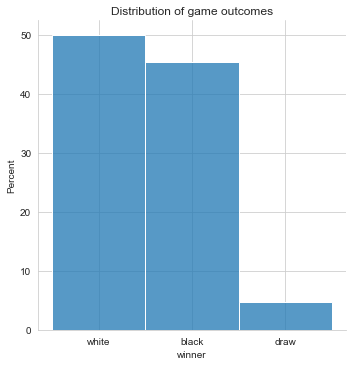

In [3]:
plt.figure()


sns.displot(chess_games['winner'], stat='percent')
plt.title('Distribution of game outcomes')
plt.show()

We now encode the response variable to take on numeric values. This is essential if we want to fit a regressional model on our data. We have chosen the following values for each outcome.

- White winning encodes to outcome 1

- Black winning encodes to outcome 0

- A draw encodes to outcome 0.5

We create a new column in our dataframe to hold this outcome code variable.

We choose 0.5 for a draw since it is definitively in between black and white. This way we treat the outcome of a draw as indecisive. Our model will predict the probability that the game falls in white's favor. This is not precisely the probability that white wins as we do not ever predict 'draw' to be the resolution of the game.

We do not think this will cause large problems as we are trying to answer the question as to which variables influence the outcome, not predict it accurately.

In [4]:
outcome_code = np.empty(len(chess_games))

# Encode correct value to outcome
for i in range(len(chess_games)):
    if chess_games['winner'][i] == 'white':
        outcome_code[i] = 1
    elif chess_games['winner'][i] == 'black':
        outcome_code[i] = 0
    else:
        outcome_code[i] = 0.5

# Save new column in dataframe
chess_games['outcome_code'] = outcome_code

print(len(chess_games))
chess_games.head()

19113


,id,rated,turns,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply,outcome_code
0,TZJHLljE,False,13,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,5,1.0
1,l1NXvwaE,True,16,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,4,0.0
2,mIICvQHh,True,61,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,3,1.0
3,kWKvrqYL,True,61,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,3,1.0
4,9tXo1AUZ,True,95,white,30+3,1523,1469,C41,Philidor Defense,5,1.0


### Explanatory variable

Explanatory variables are there to be manipulated in order to observe the response variable. The ones used in this research are “white_rating”, “black_rating”, ”opening_eco”, ”turns” and “rated”.

The first two variables, black and white rating, are discrete numerical variables that take values from 500 to 2500.

Opening_eco is a categorical variable and represents the unique code for a chess opening. For instance, French defense (one of the chess openings) has a code C00 and Polish opening A00. We chose four openings against the rest, namely French defense (C00), Polish opening (A00), Queen’s gambit (D06) and Ruy Lopez (C60-C69).

The fourth variable is the number of turns in a game (“turns”) and that is a discrete numerical variable. It takes values from 1 to approximately 100.

The categorical variable “rated” is a variable that says whether the game has influence on your rank or not. It takes two values, True or False. True for a ranked game and False for an unranked game.

Here we encode 4 dummy variables for the openings we will test against the rest of the dataset.

In [5]:
# Now encode dummy variables for some common and some known strong openings

# A00 reflects if the polish opening was played
A00 = np.empty(len(chess_games))
for i in range(len(chess_games)):
    A00[i] = chess_games['opening_eco'][i] == 'A00'

# C00 reflects if the French defense was played
C00 = np.empty(len(chess_games))
for i in range(len(chess_games)):
    C00[i] = chess_games['opening_eco'][i] == 'C00'

# QGM reflects if the Queen's gambit was played
QGM = np.empty(len(chess_games))
for i in range(len(chess_games)):
    QGM[i] = chess_games['opening_eco'][i] == 'D06'

# RLP reflects if the Ruy Lopez opening was played
RLP = np.empty(len(chess_games))
for i in range(len(chess_games)):
    RLP[i] = chess_games['opening_eco'][i].__contains__('C6')

# Create new rows for each dummy variable
chess_games['A00'] = A00
chess_games['C00'] = C00
chess_games['QGM'] = QGM
chess_games['RLP'] = RLP

We plotted some of the distributions for our continuous variables: white rating, black rating and amount of turns. We did this to spot any abnormalities in our data.

The rating distributions seems normal (except for one peak). The turns distribution is slightly right-skewed.

The peak at 1500 in rating is potentially caused by the entry level rating. That is to say the rating imposed on players that have played no matches on lichess is always 1500. We choose to keep all of these measurements.

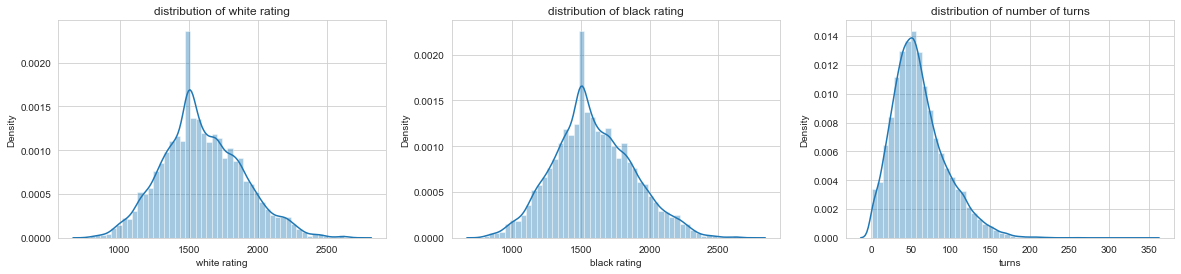

In [6]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)

sns.distplot(x=chess_games['white_rating'], ax=ax[0])
sns.distplot(x=chess_games['black_rating'], ax=ax[1])
sns.distplot(x=chess_games['turns'], ax=ax[2])
ax[0].set_xlabel('white rating')
ax[1].set_xlabel('black rating')
ax[2].set_xlabel('turns')
ax[0].set_title('distribution of white rating')
ax[1].set_title('distribution of black rating')
ax[2].set_title('distribution of number of turns')

plt.show()

We chose to also show the distributions of our numerical variables.

Each opening has a very small occurence since there are very many openings. Especially for the Queen's gambit this means that there is a low chance of showing significance.

It is notable that relatively few matches were unrated. This will reduce the chance of us finding an effect for this variable.

Frequencies of openings:
A00: 4.959975%
C00: 4.237953%
QGM: 0.873751%
RLP: 3.160153%


Text(0.5, 1.0, "distribution of 'rated' variable")

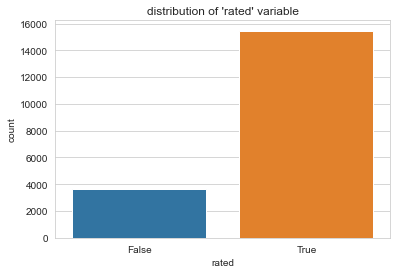

In [7]:
print('Frequencies of openings:')
print('A00: {0:2f}%'.format(len(chess_games[chess_games['A00'] == True]) * 100/len(chess_games)))
print('C00: {0:2f}%'.format(len(chess_games[chess_games['C00'] == True]) * 100/len(chess_games)))
print('QGM: {0:2f}%'.format(len(chess_games[chess_games['QGM'] == True]) * 100/len(chess_games)))
print('RLP: {0:2f}%'.format(len(chess_games[chess_games['RLP'] == True]) * 100/len(chess_games)))

plt.figure()

sns.countplot(x='rated', data=chess_games)
plt.title('distribution of \'rated\' variable')

## Methods

This study will be conducted by constructing a multiple logistic regression model, given the data from “games.csv”. We decided to use the backward selection, using the P-value approach ($\alpha=0.05$). The values that have been considered at first were: “white_rating”, “black_rating”, “opening_eco”, “rated” and “turns”.

The model shown below resulted from this backwards selection.

The variables that remained to show a significant correlation are white_rating, black_rating, A00 (Polish opening) and turns.

Outside of the Polish opening, no correlation was found between outcome and opening.

The funtion for our model is as follows:

$log_e({p_i}/{1-p_i}) = 0.3679 + 0.0036 * white rating - 0.0037 * black rating - 0.3028 * A00 - 0.0023 * turns$

Where $p_i$ is an estimate for the probability of white winning.

In [8]:
formula_1 = 'outcome_code ~ white_rating + black_rating + A00 + turns'
our_model = sm.logit(formula=formula_1, data=chess_games)
our_model_fitted = our_model.fit()
print(our_model_fitted.summary())

Optimization terminated successfully.
         Current function value: 0.617660
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           outcome_code   No. Observations:                19113
Model:                          Logit   Df Residuals:                    19108
Method:                           MLE   Df Model:                            4
Date:                Sun, 12 Jun 2022   Pseudo R-squ.:                  0.1075
Time:                        11:10:54   Log-Likelihood:                -11805.
converged:                       True   LL-Null:                       -13228.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3679      0.098      3.771      0.000       0.177       0.559
white_rating     0.0036

We still need to assess our fitted model to make sure there are no errors or confounds in the synthesis of this model. We will do so by first checking if our model indeed predicts the probabilities of white victory versus black victory correctly. Secondly, we will inspect correlations between explanatory variables to make sure there is no collinearity at play.

In [9]:
# Collect predictions of all points (long runtime)
predictions = np.empty(len(chess_games))
for i in range(len(chess_games)):
    predictions[i] = our_model_fitted.predict(chess_games.iloc[[i]])

To check if our model predicts probabilities correctly, we plot the prediction on the x-axis compared to the actual outcome on the y-axis. We use seaborn's regplot to draw a high order spline funtion that approaches the probability of white winning at each point in the y-axis. The estimated probability should be perfectly linear to the actual probability with a coefficient of 1 in a perfect model. This means that the closer we are to that situation, the better the fit of our model.

In the figure below we plot the high order spline estimating local probability alongside the linear 'perfect fit model' line.

Our model turns out to be very close to this 'perfect model'.

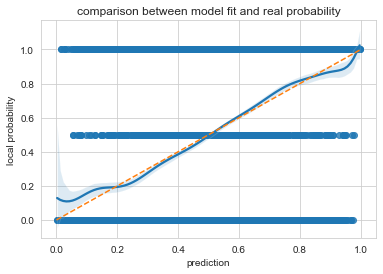

In [10]:
plt.figure()

sns.regplot(predictions, chess_games['outcome_code'], order=15)
sns.lineplot([0,1], [0,1], linestyle='--')
plt.xlabel('prediction')
plt.ylabel('local probability')
plt.title('comparison between model fit and real probability')
plt.show()

To get insight into our model, we decided to also plot the distribution of our predictions.

It appears that most often the predictions are made around the halfway point. It is slightly closer to the right, suggesting that it predicts slightly more in favor of white. This is in line with the slightly higher win rate white has in this dataset. This concentration around the center suggests that a lot of the time our model has a rather low confidence. This and the fact that our model's pseudo-R-squared is low (0.1065), suggests that our model cannot explain very much of the variability of chess games.

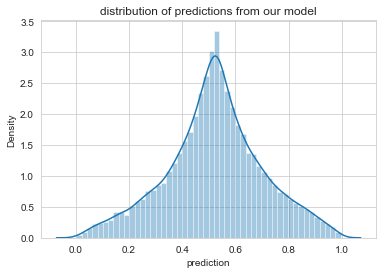

In [11]:
plt.figure()
sns.distplot(predictions)
plt.xlabel('prediction')
plt.title('distribution of predictions from our model')
plt.show()

### Collinearity

A suspected collinearity we found was between 'black rating' and 'white rating'. The plot below shows that indeed these two variables are strongly correlated. This is most likely due to the way matchmaking works on lichess. There is no reason to think however that the effect of either is due to this colinearity considering they are both correlated differently with the response variable.

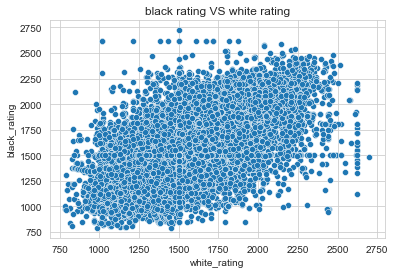

                            OLS Regression Results                            
Dep. Variable:           white_rating   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                 1.302e+04
Date:                Sun, 12 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:12:58   Log-Likelihood:            -1.3052e+05
No. Observations:               19113   AIC:                         2.611e+05
Df Residuals:                   19111   BIC:                         2.611e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      586.5860      9.004     65.146   

In [12]:
plt.figure()
sns.scatterplot(chess_games['white_rating'], chess_games['black_rating'])
plt.title('black rating VS white rating')
plt.show()
coll_model_fit_1 = sm.ols(formula='white_rating ~ black_rating', data=chess_games).fit()
print(coll_model_fit_1.summary())

Another potential collinearity is that between amount of turns and both black and white ratings.

A multiple regression analysis shows that they are indeed strongly correlated. Prodominently a high black's rating is paired with a higher number or turns and to some degree this is true for white's rating. In our original model we showed that a higher number of turns favors black while black rating and white rating influence game outcome nearly equally.

The effect of turns on game outcome can thus be explained by the stronger correlation between black rating and turns than white rating and turns. We choose to keep it in the model as it is a solid predictor. We will touch on this again in the conclusion.

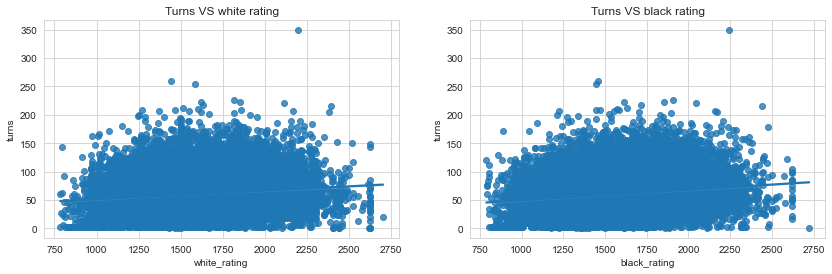

                            OLS Regression Results                            
Dep. Variable:                  turns   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     265.5
Date:                Sun, 12 Jun 2022   Prob (F-statistic):          1.83e-114
Time:                        11:13:01   Log-Likelihood:                -93967.
No. Observations:               19113   AIC:                         1.879e+05
Df Residuals:                   19110   BIC:                         1.880e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       27.8335      1.470     18.934   

In [13]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)
fig.set_figheight(4)

sns.regplot(x=chess_games['white_rating'], y=chess_games['turns'], ax=ax[0])
sns.regplot(x=chess_games['black_rating'], y=chess_games['turns'], ax=ax[1])
ax[0].set_title('Turns VS white rating')
ax[1].set_title('Turns VS black rating')
plt.show()

coll_model_fit_2 = sm.ols(formula='turns ~ white_rating + black_rating', data=chess_games).fit()
print(coll_model_fit_2.summary())

We should investigate if there is collinearity between when the Polish opening is played and the player ratings.

It turns out, as shown in the figures, that the average player rating for both black and white is lower whenever the Polish opening is played. The model below confirms that there exists a collinearity between Polish opening and player rating.

Since the coefficient is higher for white's rating, white is expected to be even lower rated than black when this opening is played. This can explain the effect that this opening has on game outcome. It can thus be due to collinearity that this effect occurs.

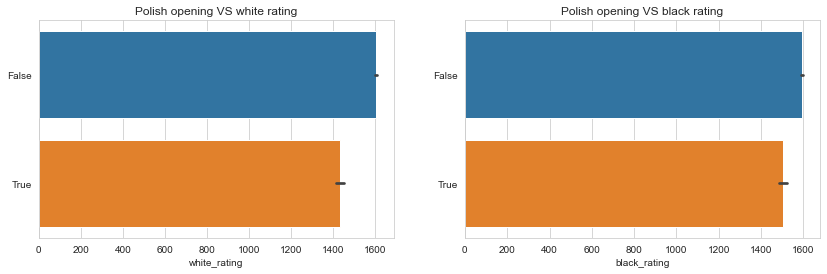

                            OLS Regression Results                            
Dep. Variable:                    A00   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     161.3
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           3.30e-70
Time:                        11:13:02   Log-Likelihood:                 2231.5
No. Observations:               19113   AIC:                            -4457.
Df Residuals:                   19110   BIC:                            -4433.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1936      0.010     20.202   

In [14]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)
fig.set_figheight(4)

sns.barplot(x=chess_games['white_rating'], y=[c == 1 for c in chess_games['A00']], ax=ax[0], orient = 'h')
sns.barplot(x=chess_games['black_rating'], y=[c == 1 for c in chess_games['A00']], ax=ax[1], orient = 'h')
ax[0].set_title('Polish opening VS white rating')
ax[1].set_title('Polish opening VS black rating')
plt.show()

coll_model_fit_3 = sm.ols(formula='A00 ~ black_rating + white_rating', data=chess_games).fit()
print(coll_model_fit_3.summary())

The last collinearity check regards the amount of turns and the playing of the Polish opening.

The barplot below shows that games in which the Polish opening was played were shorter than those in which another opening was played. The model confirms this is significant.

Either effect, that of turns and that of opening, could be caused by the collinearity between the two.

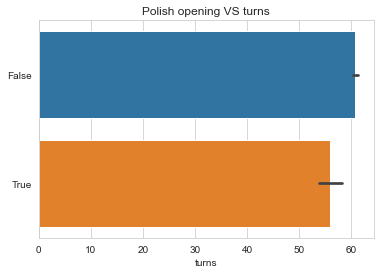

                            OLS Regression Results                            
Dep. Variable:                    A00   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.28
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           1.91e-05
Time:                        11:13:02   Log-Likelihood:                 2080.6
No. Observations:               19113   AIC:                            -4157.
Df Residuals:                   19111   BIC:                            -4142.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0617      0.003     19.040      0.0

In [15]:
plt.figure()

sns.barplot(x=chess_games['turns'], y=[c == 1 for c in chess_games['A00']], orient = 'h')
plt.title('Polish opening VS turns')
plt.show()

coll_model_fit_4 = sm.ols(formula='A00 ~ turns', data=chess_games).fit()
print(coll_model_fit_4.summary())

## Conclusion

Our final model produced the following predictor for game outcome:

$log_e({p_i}/{1-p_i}) = 0.3679 + 0.0036 * white rating - 0.0037 * black rating - 0.3679 * COO - 0.0023 * turns$

Where $p_i$ is an estimate for the probability of white winning.

This model has an pseudo R-squared of 0.1075.

Our model was able to show a strong correlation for four of the five variables proposed by us.
These are:

- White rating

- Black rating

- The Polish opening

- Amount of turns

White rating influences the game outcome in white's favor. Black rating influences the outcome in black's favor, as expected.

In this dataset, games in which the Polish opening was played, black was at a significant advantage. We expected to see some differences between this commonly played opening and other openings. We cannot conclude any causal relationships about this however, since this effect could very well be due to collinearity. We found collinearity between the Polish opening and every other significant variable.

We could not find a significant effect resulting from whether a game is rated or not. While we expected to see players put in less attention if there was nothing at stake, we stand corrected and would revise this hypothesis of ours.

The amount of turns looks to have shown a strong correlation with outcome, however also with both ratings as well as the Polish opening. We chose to keep it in our model to preserve this strong predictor. However, since the correlation between game outcome and number of turns can be explained by collinearity we cannot make conclusions about an effect of turn numbers on game outcome.

It turns out this dataset is riddled with collinearity between many variables that influence the outcome of the game. To find conclusive causal relationships from this dataset, it would have to be analysed more thoroughly. Even so, it would be difficult to infer causal relationships with this dataset since it does not follow an experimental design. Any seeming relationships could be caused by extraneous variables that are not documented in these data.